# 逻辑回归案例

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# 作图包
import os
# 路径相关包
import statsmodels.api as sm
# 统计模型包

## 乳腺癌检测

#### 使用scikit-learn自带的乳腺癌数据集

载入乳腺癌检测数据集:569个观测,30个数值型预测变量以及对应的分类(响应变量),所有的变量都是从足够多数量的良性和恶性的肿瘤病灶造影图片得到的. 

属性信息:

- radius:半径,病灶中心点离边界的平均距离
- texture:纹理,灰度值的标准差
- perimeter:周长,病灶大小
- area:面积,病灶大小
- smoothness:平滑度,半径长度的变异
- compactness:密实度,周长平方除以面积值减1,$perimeter^2/area-1.0$
- concavity:凹度,凹陷部分轮廓的严重程度
- concave points:凹点,凹陷轮廓的数量
- symmetry:对称性
- fractal dimension:分形维度

每个属性的均值,标准误,最差值(最大值)计算得到30个特征

对应212个恶性(Malignant),357个良性(Benign)

In [21]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
# 将数据的自变量给X,因变量给y

In [22]:
cancer.feature_names
# 查看数据列名

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [23]:
print(f"data shape: {X.shape}; class frequency: {dict(pd.Series(y).value_counts())}")
# 打印数据的行列数,查看y各个取值的频数

data shape: (569, 30); class frequency: {1: 357, 0: 212}


- pd.value_counts():查看所有值的频数,输入数组,返回series

#### 分训练和测试集:

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.3,random_state=1221)
# 按照7,3分训练和测试集,设置种子为1221

#### 模型训练:

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="liblinear",C=10,penalty="l1",max_iter=1000)
# 这里使用lasso回归,C表示正则化强度的负值
model.fit(X_train,y_train)
# 用训练数据拟合模型
train_score = model.score(X_train,y_train)
# 训练数据得分
test_score = model.score(X_test,y_test)
# 测试数据得分
print(f"train accuracy: {train_score:.4f}; test accuracy: {test_score:.6f}")
# 打印份数
print(f"""model coefficient:
{model.coef_};
model intercept:
{model.intercept_}""")
# 打印系数

train accuracy: 0.9849; test accuracy: 0.959064
model coefficient:
[[ 1.17432604e+00  1.08147802e-01  2.86824510e-02 -1.44750386e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.08835691e+00
  -1.27865937e+00 -9.99466892e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.48745555e-01 -6.33511497e-01  2.91601896e-01 -3.37337142e-02
   0.00000000e+00  0.00000000e+00 -7.16813901e+00 -3.59608028e+01
  -1.60074443e+01  0.00000000e+00]];
model intercept:
[6.68450933]


LogisticRegression:逻辑回归参数:

- solver:表示求参方法,有'newton-cg','lbfgs','liblinear','sag','saga'
    - 小数据集选liblinear,大数据集sag和saga快一些
    - liblinear支持L1和L2正则化项,'newton-cg','sag','lbfgs'仅支持L2正则化项
- C:正则化强度取负值,必须是正实数,默认0.1,值越小,减得越少,正则化强度越强
- penalty:"l1"表示加"l1"惩罚项,即lasso回归,"l2"表示岭回归
- max_iter:迭代次数的上限,用于算法收敛

#### 样本预测:

In [26]:
y_pred = model.predict(X_test)
# 1,0结果
y_pred_prob = model.predict_proba(X_test)[:,1]
# 预测为1的概率(得到两列预测概率,分别是预测为0和1的,这里取第二列)
print(f"""predicted value: {y_pred[:10]}
predicted probability: {y_pred_prob[:10]}""")
# 打印前十行数据的预测结果

predicted value: [1 1 0 1 0 0 0 1 0 1]
predicted probability: [9.99986891e-01 9.98183063e-01 1.67422845e-07 9.78688047e-01
 4.48581430e-20 7.67361820e-02 9.15434386e-05 9.99917290e-01
 3.25523295e-05 9.96565663e-01]


对于分类变量的预测:

- model.predict():直接预测得到分类结果
- model.predict_proba:预测得到每个分类的概率,这里第一列是0的概率,第二列是1的概率

#### 加入高次项和交叉项

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
def polynomial_model(degree=1,**kwarg):
    polynomial_features = PolynomialFeatures(degree = degree,
                                            include_bias = False)
    # 加入高次项和交互项
    logistic_regression = LogisticRegression(**kwarg)
    # 逻辑回归,通过**kwarg传递参数
    pipeline = Pipeline([("polynomial_features",polynomial_features),
                        ("logistic_regression",logistic_regression)])
    # 创建管道,即结合多项式和逻辑回归
    return pipeline

- PolynomialFeatures:创建高次项和交互项
    - degree: 多项式项数,默认为2
    - interaction_only: 是否仅包含交互项不包含高次项,默认False
    - include_bias: 是否包含截距项,默认True
- Pipeline: 变换的管道和最终的估计,一个Pipeline可以包含多个处理结点,最后一个结点只需要实现fit()方法,其他结点必须实现fit()和transform()方法,从前往后依次调用.可以通过修改每个结点的参数,使用.set_params(),设置参数书写格式为: 结点名__参数名=给定值

使用二阶多项式和交互项,L1正则化项来构建逻辑回归

In [31]:
model = polynomial_model(degree=2,penalty="l1",solver="liblinear",C=0.1)
# 通过之前的函数构建逻辑回归
model.fit(X_train,y_train)
# 回归模型拟合训练数据

Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('logistic_regression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

加入各项后,查看L1正则化后的有效特征数

In [32]:
lg_model = model.named_steps["logistic_regression"]
# 抽取模型中的逻辑回归
print(f"""model parameters shape: {lg_model.coef_.shape[1]};
after regularization: {np.count_nonzero(lg_model.coef_)}""")
# 打印逻辑回归总的系数个数,以及去掉零值后的系数个数.
# 这里生成的值为0的系数是由于lasso回归对系数压缩造成的

model parameters shape: 495;
after regularization: 49


查看表现

In [33]:
train_score = model.score(X_train,y_train)
# 训练集准确率
test_score = model.score(X_test,y_test)
# 测试集准确率
print(f"train accuracy: {train_score:.4f}; test accuracy: {test_score:.6f}")
# 打印结果

train accuracy: 0.9975; test accuracy: 0.970760


# 银行市场推广

### 银行完整数据

数据来自[UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing),是葡萄牙银行机构市场推广相关数据,手段主要是电话推广,多次与同一客户电话沟通,目的是判断用户是否会订购相关产品(定期存款),数据可以从[这里](https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv)下载

In [35]:
os.chdir("D:/data/python")
# 设置工作路径
bank = pd.read_csv("bank-additional-full.csv",header=0,sep=";")
# 读取数据,header=0表示第一行是表头,sep=";"表示数据中分隔符是分号

In [36]:
print(f"bank shape: {bank.shape}; class frequency: {dict(pd.Series(bank.y).value_counts())}")
# 查看数据行列数以及y的频数
bank.describe(include="all")
# 描述数据的每一列,include="all"表示所有列,默认等于None表示只描述数值列

bank shape: (41188, 21); class frequency: {'no': 36548, 'yes': 4640}


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


输入的变量描述:

#### bank client data:
1. - age:年龄 (numeric)
2. - job:工作类型: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. - marital:婚姻状况: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. - education:教育等级: (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. - default:有没有信用额度: has credit in default? (categorical: 'no','yes','unknown')
6. - housing:有没有住房贷款: has housing loan? (categorical: 'no','yes','unknown')
7. - loan:有没有私人贷款: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
8. - contact:电话类型: contact communication type (categorical: 'cellular','telephone') 
9. - month:上次沟通所在月份: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. - day_of_week:上次沟通在周几: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. - duration:上次沟通时长(单位:秒): last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
12. - campaign:本次推广联系次数(包括最后一次): number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. - pdays:上次推广最后一次联系距今天数(999表示之前没有联系过): number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. - previous:本次推广之前的联系次数: number of contacts performed before this campaign and for this client (numeric)
15. - poutcome:之前推广结果: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
16. - emp.var.rate:就业变异率: employment variation rate - quarterly indicator (numeric)
17. - cons.price.idx:消费者物价指数: consumer price index - monthly indicator (numeric) 
18. - cons.conf.idx:消费者信心指数: consumer confidence index - monthly indicator (numeric) 
19. - euribor3m:3个月欧元区银行同业拆借利率: euribor 3 month rate - daily indicator (numeric)
20. - nr.employed:职工人数: number of employees - quarterly indicator (numeric)

#### 响应变量:

21. - y:客户有没有订购定期存款 - has the client subscribed a term deposit? (binary: 'yes','no')

### 数据描述和清洗

#### 依据业务逻辑处理数据

对因变量y重新赋值,yes改为1,no改为0

In [37]:
bank.y = np.where(bank.y == "yes" ,1, 0)
# 将"yes"替换成1,其余改为0
bank.y.value_counts()
# 查看y的频数

0    36548
1     4640
Name: y, dtype: int64

np.where: 三个参数:第一个参数condition表示判断条件,需要一个布尔列表,后面两个参数分别是True和False时替换的值

对教育等级重分箱

In [287]:
bank.education.value_counts()
# 查看教育等级的频数

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [38]:
bank.education = np.where(
    (bank.education=="basic.9y")|(bank.education=="basic.6y")|(
        bank.education=="basic.4y"),"Basic",bank.education)
# 多个条件取或,只有有一个满足就是True,用"Basic"替换,其余用原数据替换

In [39]:
bank.education.value_counts()
# 查看重分箱后新的频数

Basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64

pdays变量中999表示之前没有联系过,发现999占比很高,故将999改为"no",将其他改为"yes"

In [40]:
no_pdays=sum(bank.pdays == 999)/bank.shape[0]
# 查看pdays列中999的占比
print(f"rate of none contacted clients: {no_pdays:.4f}")
# 打印占比值
bank.pdays = np.where(bank.pdays == 999, "no","yes")
# 对于pdays列,凡是999替换成"no",其余替换成"yes"
bank.pdays.value_counts()
# 查看变换后数据的频数

rate of none contacted clients: 0.9632


no     39673
yes     1515
Name: pdays, dtype: int64

查看各连续变量在不同分类下的均值

In [41]:
bank.groupby("y").mean()
# 对数据依据y列进行分组,查看每列在每组下的均值

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,
0,39.911185,220.844807,2.633085,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


由于是预测性分析,根据变量性质,去掉duration

In [42]:
bank.drop(columns="duration",inplace=True)
# 去掉指定列, inplace=True表示在原数据上更改

由于job变量中包含的分类名"admin."包含"."非常不友好,所以改为"admin"

In [43]:
bank.job = np.where(bank.job=="admin.","admin",bank.job)
# job列中凡是等于"admin."的值替换成"admin",其余原数据替换
bank.job.value_counts()
# 查看频数

admin            10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

#### 数据描述

查看各连续变量在不同分类下的分布情况

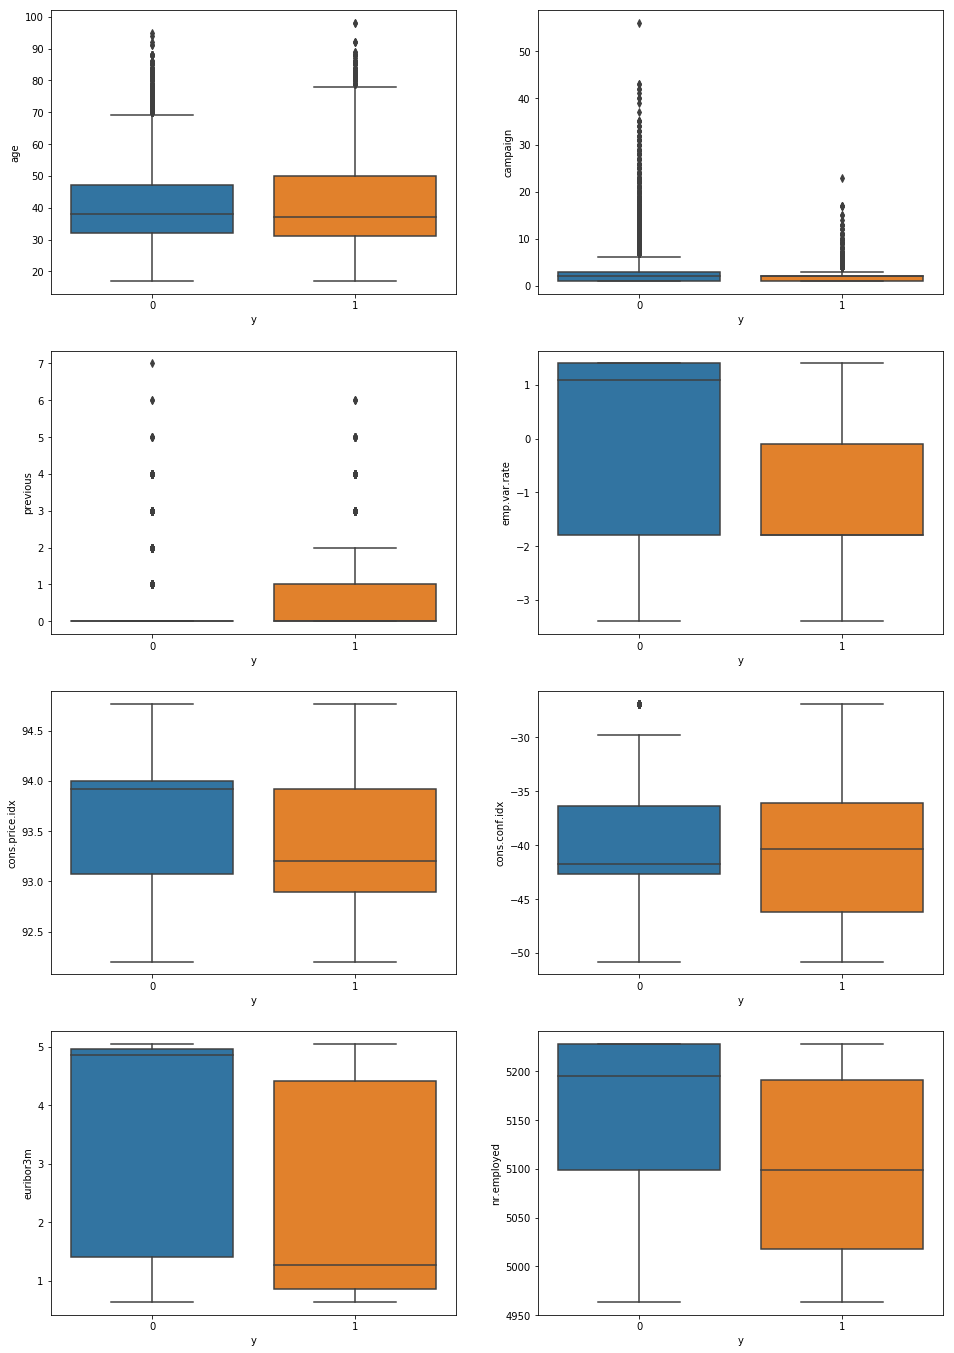

In [44]:
colnames = list(bank.iloc[:,[0,10,12,14,15,16,17,18]].columns.values)
# 找到所有数值列的索引位置,抽子集,columns.values抽取列名,通过list()将列名生成列表
fig,axs=plt.subplots(nrows=4,ncols=2,figsize=(16,24))
# 设置子图的布局,4行2列,生成两个对象,axs表示每个子图的位置
for i,r in enumerate(colnames):
    sns.boxplot(x="y",y=r,data=bank,ax=axs[i//2,i%2])

- 使用seaborn中的箱线图函数boxplot,对每个数值列画图
    - x:赋值x轴数据对应的列名
    - y:赋值y轴对应的列名
    - data:是数据框的名字
    - ax:给之前生成的axs的子集,两个值表示图形的位置,1行1列的子图即$axs[0,0]$
- enumerate表示枚举,即每个元素匹配一个索引值组成元祖,如下例

In [45]:
list(enumerate([1,3,4]))

[(0, 1), (1, 3), (2, 4)]

查看各分类变量在不同y分类下的分布情况

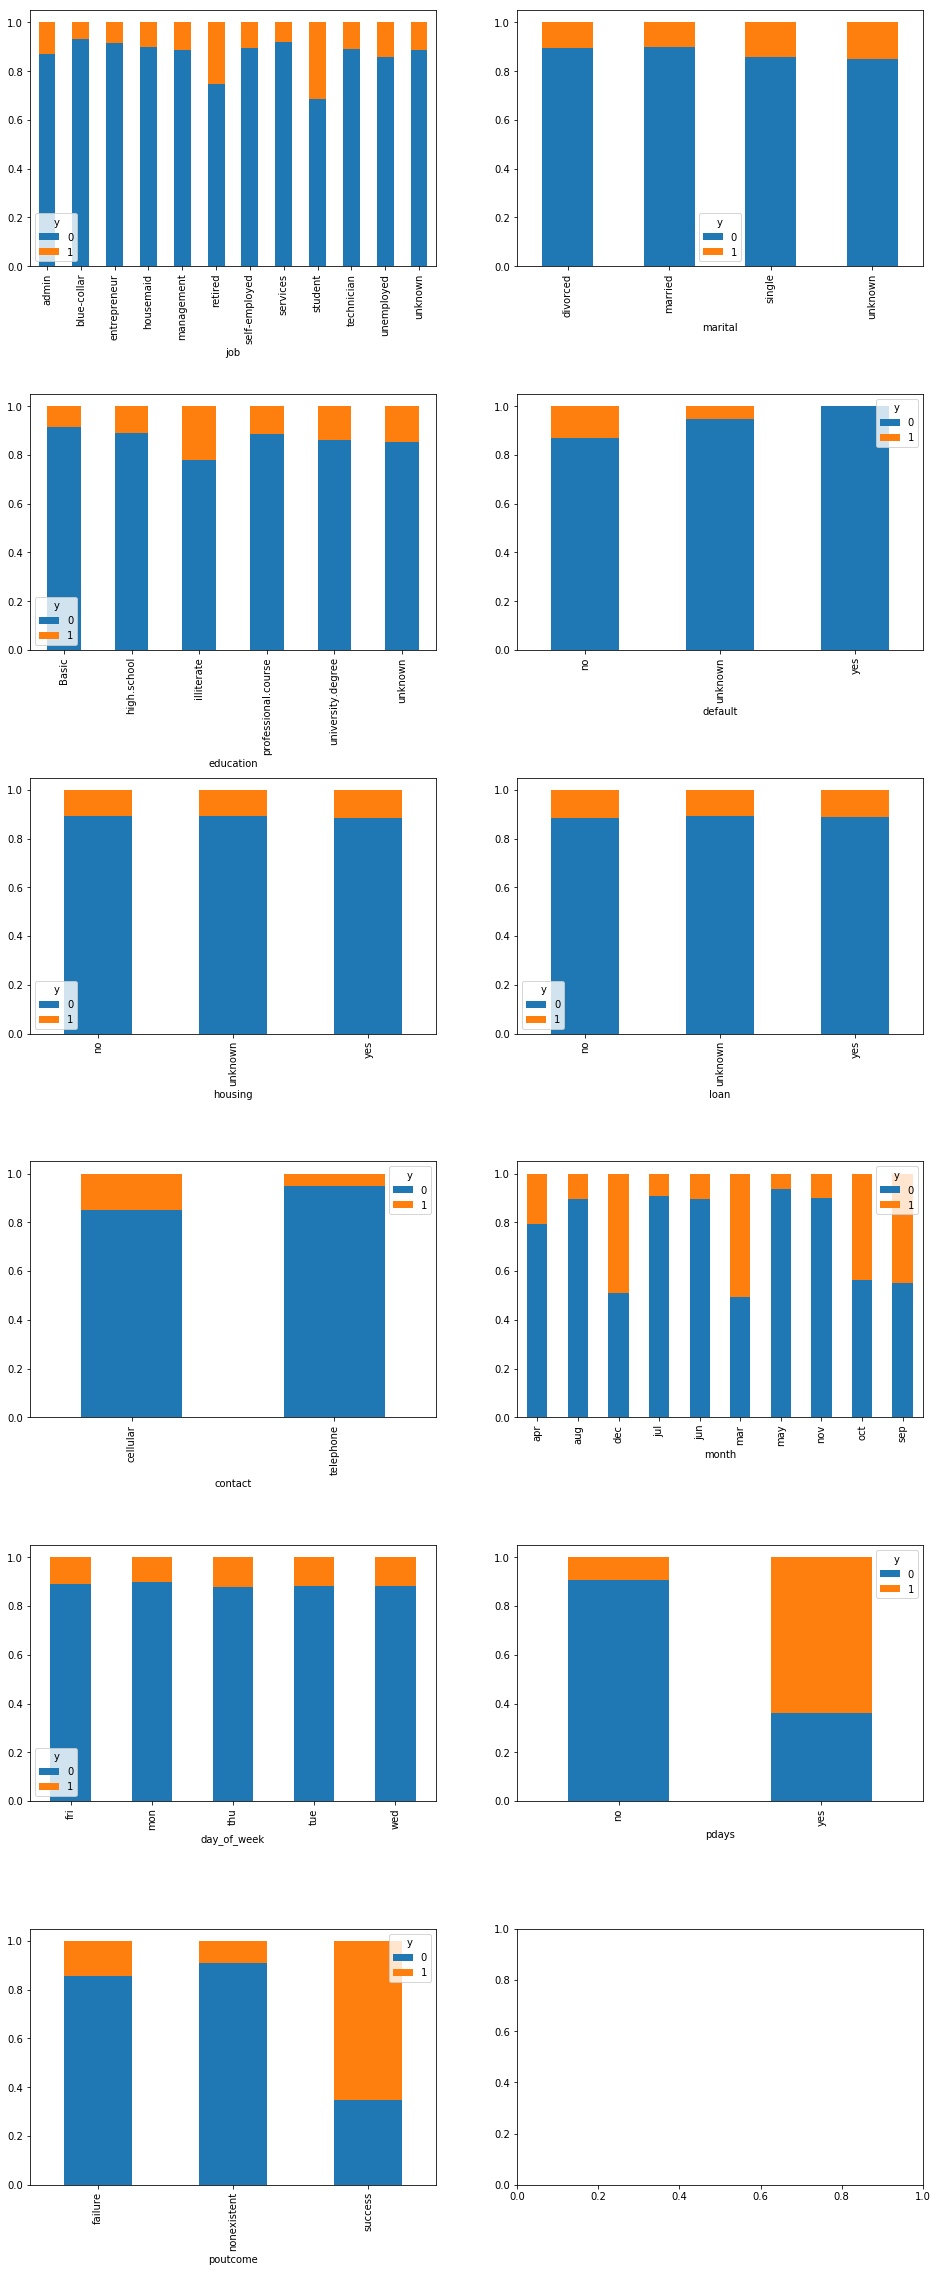

In [46]:
from matplotlib.figure import SubplotParams
# 这个函数为了控制多图布局中的每个图形之间的间隔
colnames1 = list(bank.iloc[:,[1,2,3,4,5,6,7,8,9,11,13]].columns.values)
# 根据非数值列的索引,抽取列名
fig,axs=plt.subplots(nrows=6,ncols=2,figsize=(16,40),
                     subplotpars = SubplotParams(hspace = 0.5))
# 子图是6行2列,hspace表示每个图之间的垂直距离是0.5
for i,r in enumerate(colnames1):
    table= pd.crosstab(bank[r],bank.y)
    # 根据非数值列和y列创建交叉表
    table.div(table.sum(1).astype(float),axis=0).plot(
        kind="bar",stacked=True,ax=axs[i//2,i%2])
    # table.sum(1)表示求行和
    # .astype(float)生成结果转为实数
    # .div(a,axis=0)表示每列除以a
    # 上式就得到每个数的行百分比
    # 依据行百分比作图,kind="bar"表示条形图
    # stacked=True表示堆积条形图,如下
    # ax指定每个图的位置,如axs[1,1]表示2行2列

上述代码例子:

In [47]:
tt = pd.crosstab(np.array([1,1,0,0,0]),np.array([1,1,1,0,0]))
print(tt)
print(tt.sum(1))
print(tt.sum(1).astype(float))
print(tt.div(tt.sum(1).astype(float),axis=0))

col_0  0  1
row_0      
0      2  1
1      0  2
row_0
0    3
1    2
dtype: int64
row_0
0    3.0
1    2.0
dtype: float64
col_0         0         1
row_0                    
0      0.666667  0.333333
1      0.000000  1.000000


#### 建模

生成哑变量

In [52]:
def gen_dummy(X):
# 构建生成哑变量的函数
    for var in X.columns:
    # 对X的每一列循环
        if X[var].dtype==object:
        # 如果此列的类型是object,即非数值列
            dummy = pd.get_dummies(X[var],prefix=var)
            # 生成哑变量
            X = X.join(dummy.iloc[:,1:])
            # 将哑变量除去第一列以外的所有列结合到原数据中
            del X[var]
            # 删除生成哑变量的原始数据列
    return(X)
bank_f = gen_dummy(bank)
# 通过上面的哑变量函数处理数据框
bank_f.columns.values
# 查看生成哑变量后的列名

array(['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'pdays_yes',
       'poutcome_nonexistent', 'poutcome_success'], dtype=object)

- pd.get_dummies():生成哑变量:有几个分类就生成几个哑变量,每个哑变量中,该分类对应数值为1,其他为0.
    - prefix:表示哑变量的前缀名

分训练和测试集

In [53]:
X = bank_f.drop(columns="y")
# 去掉y列用其他列生成自变量数据X
y = bank.y
# 抽取因变量数据y

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.3,random_state=1221)
# 分训练测试集

lasso回归筛选变量

In [57]:
model = LogisticRegression(solver="liblinear",C=0.02,penalty="l1",max_iter=1000)
# 使用liblinear算法估计系数,正则化项系数C是0.02,值较小,正则化强度较强
# 添加"l1"正则化项,即lasso回归
model.fit(X_train,y_train)
# 使用训练数据拟合模型
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)
# 得到训练集和测试集的准确率
print(f"train accuracy: {train_score:.4f}; test accuracy: {test_score:.4f}")
# 打印准确率
print(f"""model coefficient:
{model.coef_};
model intercept:
{model.intercept_}""")
# 打印模型的所有系数值和截距项值

train accuracy: 0.8988; test accuracy: 0.9011
model coefficient:
[[ 9.48285753e-04 -4.26677532e-02  0.00000000e+00 -2.86302780e-01
   3.30101895e-01  2.07910969e-02 -1.35963098e-02 -6.22966236e-03
  -1.10097924e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.85079367e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.43549513e-02  0.00000000e+00 -1.06052438e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.43367459e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.93729759e-01 -6.02718321e-01
  -1.62989905e-01  0.00000000e+00  0.00000000e+00 -1.79675824e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  9.51277887e-01
   2.32147544e-01  4.29012180e-01]];
model intercept:
[0.]


In [58]:
ind = model.coef_ != 0.
# 得到系数值不等于0的布尔索引
ind = ind.ravel()
# 将索引降维成1维数组
X_train.columns.values[ind]
# 查看系数值不等于0的列的列名

array(['age', 'campaign', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar',
       'marital_single', 'education_university.degree', 'default_unknown',
       'contact_telephone', 'month_mar', 'month_may', 'month_nov',
       'day_of_week_mon', 'pdays_yes', 'poutcome_nonexistent',
       'poutcome_success'], dtype=object)

与筛选前的列对比

In [59]:
X_train.columns.values
# 抽取筛选前X的列名

array(['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'pdays_yes',
       'poutcome_nonexistent', 'poutcome_success'], dtype=object)

根据筛选结果筛选训练和测试集

In [60]:
X_train = X_train.iloc[:,ind]
X_test = X_test.iloc[:,ind]
# 对训练集和测试集使用之前得到的索引筛选

逻辑回归

In [62]:
model = sm.Logit(y_train,X_train).fit()
# 用训练集拟合逻辑回归
model.summary()
# 查看模型详细信息

Optimization terminated successfully.
         Current function value: 0.277916
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28812
Method:                           MLE   Df Model:                           18
Date:                Thu, 21 Mar 2019   Pseudo R-squ.:                  0.2167
Time:                        01:54:02   Log-Likelihood:                -8012.6
converged:                       True   LL-Null:                       -10230.
                                        LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
age                             0.0031      0.002      1.536      0.125      -0.001       0.007
campaign                       -0.0471      0.011     -4.280      0.000      -0.069      -0.026
emp.var.rate                   -0.6211      0.073     -8.518      0.000      -0.764      -0.478
cons.price.idx                  0.4676      0.033     14.096      0.000       0.403       0.533
cons.conf.idx                   0.0072      0.005      1.501      0.133      -0.002       0.016
euribor3m                       0.4147      0.087      4.759      0.000       0.244       0.586
nr.employed                    -0.0092      0.001    -13.819      0.000      -0.010      -0.008
job_blue-collar                -0.1890      0.062     -3.048      0.002      -0.310      -0.067
marital_single                  0.1121      0.051      2.196      0.028       0.012       0.212
education_university.degree     0.0584      0.047      1.242      0.214      -0.034       0.150
default_unknown                -0.2678      0.069     -3.899      0.000      -0.402      -0.133
contact_telephone              -0.6144      0.066     -9.303      0.000      -0.744      -0.485
month_mar                       0.9610      0.116      8.292      0.000       0.734       1.188
month_may                      -0.5778      0.057    -10.165      0.000      -0.689      -0.466
month_nov                      -0.6176      0.085     -7.267      0.000      -0.784      -0.451
day_of_week_mon                -0.3375      0.054     -6.234      0.000      -0.444      -0.231
pdays_yes                       1.2568      0.214      5.865      0.000       0.837       1.677
poutcome_nonexistent            0.5827      0.068      8.604      0.000       0.450       0.715
poutcome_success                0.6595      0.218      3.031      0.002       0.233       1.086
===============================================================================================
"""

预测,这里预测结果就是$y=1$的概率

In [64]:
y_pred = model.predict(X_test)
# 对测试集预测,得到的结果是y=1的概率

绘制ROC曲线

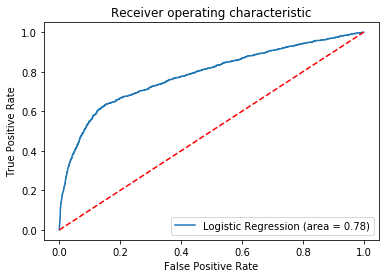

In [65]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# 这两个函数用来得到auc值和画roc曲线
logit_roc_auc = roc_auc_score(y_test, y_pred)
# 通过测试集的真实值和预测得到的概率值计算auc面积
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# 通过给定真实值和预测概率得到fpr,tpr,和对应的阈值
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# 画roc曲线,添加文本说明auc面积
plt.plot([0, 1], [0, 1],'r--')
# 添加基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
# 添加x轴,y轴标签和标题
plt.legend(loc="lower right")
# 说明图例在右下角
plt.show()

参考:

[Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)